# 04: Creating a CF-NetCDF file

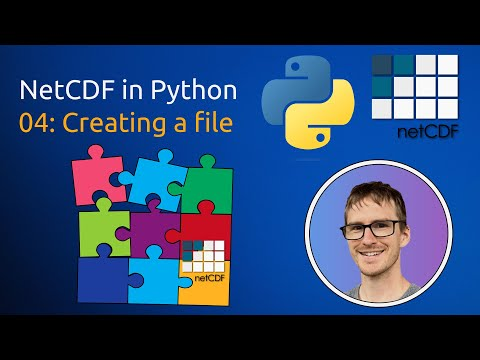

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('a5QvdSffqrM')

In this session we will create a basic NetCDF file that compliant with the Attribute Convention for Data Discovery (ACDD) and Climate and Forecast (CF) convention. 

Firstly, let's import the modules that we will work with.

In [2]:
import xarray as xr 
from datetime import datetime as dt 
import numpy as np 
import pandas as pd 

## Initialising your xarray dataset object

The first step is to create an empty xarray dataset object. 

In [3]:
xrds = xr.Dataset()
xrds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

Right away we can see the object has a defined structure with dimensions and variables. A key feature of a NetCDF file is that there is a defined structure so your data and metadata will always be in the same place within the file. This makes it easier for a machine to read it. We will add more types of data and metadata to this object as we go.

## Dimensions and coordinate variables

Dimensions define the shape of your data. Variables (your data) can be assigned one or more dimensions. A dimension in most cases is a spatial or temporal dimension (e.g. time, depth, latitude, longitude) but could also be something else (e.g. iteration, number of vertices for data representative of cells).

Dimensions tell you how many points you have for each coordinate. Coordinate variables tell you what the values for those points are.

Let's imagine a few simple scenarios. I'll initialise new xarray dataset objects each time.

### Our data are a time series with 10 points in time

In [4]:
time = [0,1,2,3,4,5,6,7,8,9]

xrds = xr.Dataset(
    coords = {
        'time': time
    }
)

xrds

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    *empty*

The object has a dimension of length 10 and a coordinate variable (time) which has a dimension of time. The values are all integers. Some more examples. 

### Your times are timestamps

There are specific recommendations on how time should be stored in NetCDF-CF files. I will try to explain briefly here, and there is a nice explanation here too: https://www.unidata.ucar.edu/software/netcdf/time/recs.html

It is most common to have a dimension named "time" as well as a coordinate variable with the same name. Let's discuss the variable first.

The "time" variable has units that count from a user defined origin, for example "hours since 2020-01-01 00:00 UTC" or "days since 2014-01-01". The units may be in years, days, seconds, nanoseconds, etc. Whilst this approach may seem strange at a glance, it allows the times to be stored in conventional numerical formats such as integers or floats, and to our desired precision. This is much more efficient than using a long timestamp string for each coordinate.

Some softwares know how to interpret this and will convert the data into timestamps in when you extract the data from a CF-NetCDF file.

Let's start by creating an array of timestamps

In [5]:
start = np.datetime64('2022-01-01T00:00:00')
end = start + np.timedelta64(24, 'h')
timestamps = np.arange(start, end, np.timedelta64(1, 'h'))

timestamps

array(['2022-01-01T00:00:00', '2022-01-01T01:00:00',
       '2022-01-01T02:00:00', '2022-01-01T03:00:00',
       '2022-01-01T04:00:00', '2022-01-01T05:00:00',
       '2022-01-01T06:00:00', '2022-01-01T07:00:00',
       '2022-01-01T08:00:00', '2022-01-01T09:00:00',
       '2022-01-01T10:00:00', '2022-01-01T11:00:00',
       '2022-01-01T12:00:00', '2022-01-01T13:00:00',
       '2022-01-01T14:00:00', '2022-01-01T15:00:00',
       '2022-01-01T16:00:00', '2022-01-01T17:00:00',
       '2022-01-01T18:00:00', '2022-01-01T19:00:00',
       '2022-01-01T20:00:00', '2022-01-01T21:00:00',
       '2022-01-01T22:00:00', '2022-01-01T23:00:00'],
      dtype='datetime64[s]')

In CF-NetCDF, time is stored in e.g. seconds since 2022-01-01T00:00:00Z, hours since 2022-01-01T00:00:00Z

In [6]:
seconds_since_start = (timestamps - start).astype('int')
seconds_since_start

array([    0,  3600,  7200, 10800, 14400, 18000, 21600, 25200, 28800,
       32400, 36000, 39600, 43200, 46800, 50400, 54000, 57600, 61200,
       64800, 68400, 72000, 75600, 79200, 82800])

In [7]:
hours_since_start = (timestamps - start).astype('timedelta64[h]').astype('int')
hours_since_start

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

Finally, let's add the time values to a coordinate variable in an xarray object.

In [8]:
xrds = xr.Dataset(
    coords = {
        'time': seconds_since_start
        }
    )

xrds

<xarray.Dataset>
Dimensions:  (time: 24)
Coordinates:
  * time     (time) int64 0 3600 7200 10800 14400 ... 72000 75600 79200 82800
Data variables:
    *empty*

### We have multiple dimensions

Let's quickly create some arrays of values to use as different coordinate variables and add them to a new xarray object.

In [9]:
depth = [0,10,20,50,100]
latitude = [78.5425, 79.1423, 80.7139]
longitude = [30.0131,28.7269]

xrds = xr.Dataset(
    coords = {
        'depth': depth,
        'latitude': latitude,
        'longitude': longitude
    }
)

xrds

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth      (depth) int64 0 10 20 50 100
  * latitude   (latitude) float64 78.54 79.14 80.71
  * longitude  (longitude) float64 30.01 28.73
Data variables:
    *empty*

## Data Variables

Now let's add some data variables. Starting from the xarray dataset object created directly above that has multiple dimensions.

You can choose what name you assign for each variable. This is not standardised, but be sensible and clear. I will show you how to make your data variables conform to the CF conventions using variable attributes using metadata a bit further down in this chapter.

### 1D array, e.g. a depth profile

In [10]:
chlorophyll_a = [21.5, 18.5, 17.6, 16.8, 15.2] # Must be same length as the depth dimension

xrds['chlorophyll_a'] = ("depth", chlorophyll_a)

xrds

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2

### 2D array, e.g. a grid of latitude and longitudes

In [11]:
wind_speed = np.random.randint(0, 10, size=(3, 2))    # Creating a 2D array
wind_speed

array([[4, 6],
       [9, 2],
       [9, 2]])

In [12]:
xrds['wind_speed'] = (["latitude", "longitude"], wind_speed)
xrds

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 4 6 9 2 9 2

Now you can see that the wind_speed variable has two dimensions; latitude and longitude. It appears as a 1D array above, but when we retrieve it we see that it isn't.

In [13]:
xrds['wind_speed']

<xarray.DataArray 'wind_speed' (latitude: 3, longitude: 2)>
array([[4, 6],
       [9, 2],
       [9, 2]])
Coordinates:
  * latitude   (latitude) float64 78.54 79.14 80.71
  * longitude  (longitude) float64 30.01 28.73

This is another major advantage of NetCDF files over tabular data formats like CSV or XLSX, which are limited in their ability to store multi-dimensional data. This multidimensional array can be used by code and software as it is without having to do any pre-processing.

### Example of 3D data

In [14]:
temperature = np.random.randint(20,30, size=(3,2,5))

xrds['temperature'] = (["latitude", "longitude", "depth"], temperature)
xrds

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 4 6 9 2 9 2
    temperature    (latitude, longitude, depth) int64 22 25 28 20 ... 29 24 26

### 3D data from pandas dataframe to 3D grid

Many people prefer to record their data first in a table, perhaps a CSV file or XLSX file. These data can be loaded into a pandas dataframe. 

Is there a way to transform your tabular data into multidimensional arrays? I'll create a dummy dataframe first

In [15]:
# Create lists to store the coordinates and salinity values
depth_coordinates = []
latitude_coordinates = []
longitude_coordinates = []
salinity_values = []

# Generate the coordinates and salinity values for the grid
for d in depth:
    for lat in latitude:
        for lon in longitude:
            depth_coordinates.append(d)
            latitude_coordinates.append(lat)
            longitude_coordinates.append(lon)
            salinity = np.random.uniform(30, 35)  # Random salinity value between 30 and 35
            salinity_values.append(salinity)

# Create a DataFrame
data = {
    'Depth': depth_coordinates,
    'Latitude': latitude_coordinates,
    'Longitude': longitude_coordinates,
    'Salinity': salinity_values
}

df = pd.DataFrame(data)
df

,Depth,Latitude,Longitude,Salinity
0,0,78.5425,30.0131,33.622934
1,0,78.5425,28.7269,32.186991
2,0,79.1423,30.0131,30.659778
3,0,79.1423,28.7269,33.962803
4,0,80.7139,30.0131,32.973053
5,0,80.7139,28.7269,31.829801
6,10,78.5425,30.0131,30.142901
7,10,78.5425,28.7269,33.518671
8,10,79.1423,30.0131,31.802748
9,10,79.1423,28.7269,30.525282


Now, let's create a multidimensional grid for our salinity variable. We need to be a bit careful with the order here. The dataframe is sorted first by depth (5 depths), then by latitude (3 latitudes), then by longitude (2 longitudes). We should mirror that order.

In [16]:
salinity_3d_array = np.array(df['Salinity']).reshape(5,3,2)
salinity_3d_array

array([[[33.62293383, 32.18699116],
        [30.65977827, 33.96280268],
        [32.97305267, 31.82980051]],

       [[30.14290084, 33.5186714 ],
        [31.80274767, 30.52528155],
        [30.09057322, 32.71881746]],

       [[34.33219077, 33.50817531],
        [34.1069542 , 34.34160461],
        [30.93894806, 31.7712962 ]],

       [[32.55988121, 33.60437791],
        [34.68379801, 30.23804545],
        [32.08238447, 30.74944872]],

       [[31.78173197, 32.32044399],
        [32.40007812, 33.44888098],
        [33.7524908 , 32.82253346]]])

In [17]:
xrds['salinity'] = (["depth", "latitude", "longitude"], salinity_3d_array) 
# Careful again with the order of your dimensions - it will fail if you get it wrong
xrds

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 4 6 9 2 9 2
    temperature    (latitude, longitude, depth) int64 22 25 28 20 ... 29 24 26
    salinity       (depth, latitude, longitude) float64 33.62 32.19 ... 32.82

## Metadata (attributes)

Hurrah! Your data are in the xarray dataset object. But are you ready to export a NetCDF file? Will that file be compliant with the FAIR principles? No! We need metadata.

Variable attributes are metadata that describe the variables. Global attributes are metadata that describe the file as a whole. You can find a list of attributes here provided by the Climate & Forecast (CF) conventions:
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#attribute-appendix

The table in the link above specifies which attributes can be used as global attributes and which can be used as variable attributes. Some attributes can be used as either.

The CF conventions are light on discovery metadata. Discovery metadata are metadata that can be used to find data. For example, when and where the data were collected and by whom, some keywords etc. So we also use the ACDD convention - The Attribute Convention for Data Discovery.
https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3

This is a list of recommendations. SIOS advises that people follow the requirements of the Arctic Data Centre, here. Requirements are a more effective way to encourage consistency than recommendations. These requirements are compliant with the ACDD conventions:
https://adc.met.no/node/4

### Variable attributes

The CF conventions provide examples of which variable attributes you should be including in your CF-NetCDF file. For example for latitude:
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.10/cf-conventions.html#latitude-coordinate

Let's replicate that setup.

Additionally, the ACDD convention recommends that and attribute *coverage_content_type* is also added, which is used to state whether the data are *modelResult*, *physicalMeasurement* or something else, see the list here: 
https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3#Highly_Recommended_Variable_Attributes

And remember we might want to select additional applicable attributes for our variables from this section of the CF conventions:
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#attribute-appendix


In [18]:
xrds['latitude'].attrs['standard_name'] = 'latitude' # One at a time

# Or all at once. Variable attributes can be written from a python dictionary
xrds['latitude'].attrs = {
    'standard_name': 'latitude',
    'long_name': 'latitude',
    'units': 'degrees_north',
    'coverage_content_type': 'coordinate'
}

xrds['latitude']

<xarray.DataArray 'latitude' (latitude: 3)>
array([78.5425, 79.1423, 80.7139])
Coordinates:
  * latitude  (latitude) float64 78.54 79.14 80.71
Attributes:
    standard_name:          latitude
    long_name:              latitude
    units:                  degrees_north
    coverage_content_type:  coordinate

In [19]:
xrds['longitude'].attrs = {
    'standard_name': 'longitude',
    'long_name': 'longitude',
    'units': 'degrees_east',
    'coverage_content_type': 'coordinate'
}
xrds['depth'].attrs = {
    'standard_name': 'depth',
    'long_name': 'depth below sea level',
    'units': 'meters',
    'coverage_content_type': 'coordinate',
    'positive': 'down'
}
xrds['chlorophyll_a'].attrs = {
    'standard_name': 'mass_concentration_of_chlorophyll_a_in_sea_water',
    'long_name': 'a description about each variable in your own words',
    'units': 'μg m-3',
    'coverage_content_type': 'physicalMeasurement',
}
xrds['salinity'].attrs = {
    'standard_name': 'sea_water_salinity',
    'long_name': 'a description about each variable in your own words',
    'units': '1e-3',
    'coverage_content_type': 'physicalMeasurement',
}
xrds['temperature'].attrs = {
    'standard_name': 'sea_water_temperature',
    'long_name': 'a description about each variable in your own words',
    'units': 'degreesC',
    'coverage_content_type': 'physicalMeasurement',
}
xrds['wind_speed'].attrs = {
    'standard_name': 'wind_speed',
    'long_name': 'a description about each variable in your own words',
    'units': 'm s-1',
    'coverage_content_type': 'physicalMeasurement',
}
# And so on for each variable..

xrds


<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 4 6 9 2 9 2
    temperature    (latitude, longitude, depth) int64 22 25 28 20 ... 29 24 26
    salinity       (depth, latitude, longitude) float64 33.62 32.19 ... 32.82

### Global attributes

As mentioned above, the requirements of the Arctic Data Centre for global attributes (based on the ACDD convention) can serve as a guide for which global attributes you should be including. https://adc.met.no/node/4

And remember we might want to select additional applicable global attributes from this section of the CF conventions:
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#attribute-appendix

Go through and add each required attribute and any others you wish to. You are also welcome to add any global attributes from the CF conventions as well as any custom attributes on top of these requirements. Similarly to variable attributes, this can either be done one by one or all in one in a dictionary. 

In [20]:
xrds.attrs['title'] = 'my title' # One by one

# Or altogether (this will overwrite any you have previously added one by one)
xrds.attrs = {
    'id': 'your_unique_id_here',
    'naming_authority': 'institution that provides the id',
    'title': 'my title',
    'summary': 'analagous to an abstract in the paper, describing the data and how they were collected and processed',
    'creator_type': 'person',
    'creator_name': 'John Smith; Luke Marsden', # Who collected and processed the data up to this point
    'creator_email': 'johns@unis.no; lukem@met.no',
    'creator_institution': 'The University Centre in Svalbard (UNIS); Norwegian Meteorological Institute (MET)',
    'creator_url': '; https://orcid.org/0000-0002-9746-544X', # OrcID is best practice if possible. Other URLs okay, or leave blank for authors that don't have one.
    'time_coverage_start': '2020-05-10T08:14:58Z',
    'time_coverage_end': '2020-05-10T11:51:12Z',
    'keywords': 'wind_speed, sea_water_temperature, sea_water_salinity, mass_concentration_of_chlorophyll_a_in_sea_water',
    'keywords_vocabulary': 'CF:NetCDF COARDS Climate and Forecast Standard Names',
    'institution': 'Your Institution',
    'publisher_name': 'Publisher Name', # Data centre where your data will be published
    'publisher_email': 'publisher@email.com',
    'publisher_url': 'publisher_url_here',
    'license': 'https://creativecommons.org/licenses/by/4.0/',
    'Conventions': 'ACDD-1.3, CF-1.8', # Choose which ever version you will check your file against using a compliance checker
    'project': 'Your project name'
}

In this case, it makes sense to some attributes based on information we have already provided.

In [21]:
xrds.attrs['geospatial_lat_min'] = min(xrds['latitude'].values)
xrds.attrs['geospatial_lat_max'] = max(xrds['latitude'].values)
xrds.attrs['geospatial_lon_min'] = min(xrds['longitude'].values)
xrds.attrs['geospatial_lon_max'] = max(xrds['longitude'].values)

We can include the current time in the *date_created* and *history* attributes.

In [22]:
dtnow = dt.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
xrds.attrs['date_created'] = dtnow
xrds.attrs['history'] = f'File created at {dtnow} using xarray in Python by John Smith'
xrds.attrs

{'id': 'your_unique_id_here',
 'naming_authority': 'institution that provides the id',
 'title': 'my title',
 'summary': 'analagous to an abstract in the paper, describing the data and how they were collected and processed',
 'creator_type': 'person',
 'creator_name': 'John Smith; Luke Marsden',
 'creator_email': 'johns@unis.no; lukem@met.no',
 'creator_institution': 'The University Centre in Svalbard (UNIS); Norwegian Meteorological Institute (MET)',
 'creator_url': '; https://orcid.org/0000-0002-9746-544X',
 'time_coverage_start': '2020-05-10T08:14:58Z',
 'time_coverage_end': '2020-05-10T11:51:12Z',
 'keywords': 'wind_speed, sea_water_temperature, sea_water_salinity, mass_concentration_of_chlorophyll_a_in_sea_water',
 'keywords_vocabulary': 'CF:NetCDF COARDS Climate and Forecast Standard Names',
 'institution': 'Your Institution',
 'publisher_name': 'Publisher Name',
 'publisher_email': 'publisher@email.com',
 'publisher_url': 'publisher_url_here',
 'license': 'https://creativecommon

## Exporting your xarray object to a NetCDF file

Finally you need to export your data. Firstly, you can specify how each variable should be encoded. This is an optional step - it will be assumed from the data type in python if you don't specify the encoding manually.

* Fill values: The fill value will be used to fill in any missing values. It should be an unrealistic value that will obviously show up as a spike in the data when plotted. The _FillValue is a special variable attribute that some softwares can understand, so when one opens the data, the fill values are replaced by NaNs again.
* dtype: What type of data does your variable contain? Characters? Integers? Decimal numbers? Some commonly used *dtype* values are:
    * float32 / float64: Ideal for storing decimal numbers with single (32-bit) or double (64-bit) precision.
    * int32 / int64: Integers of different sizes. int32 is suitable in most cases. int64 is appropriate for very large integers or when precision is crucial.
    * S1 / S10 / S100: Useful for storing string data in arrays where strings have a consistent and known maximum length. *S10* defines a string length of 10, for example.

In [23]:
# Specifiy encoding - you can write a file without this and encoding will be assumed, but you should check in any case.
myencoding = {
    'depth': {
        'dtype': 'int32',
        '_FillValue': None # Coordinate variables should not have fill values.
        },
    'latitude': {
        'dtype': 'float32',
        '_FillValue': None # Coordinate variables should not have fill values.
        },
    'longitude': {
        'dtype': 'float32',
        '_FillValue': None # Coordinate variables should not have fill values.
        },
    'chlorophyll_a': {
        'dtype': 'float32',
        '_FillValue': 1e30,
        'zlib': False
        }, 
    'wind_speed': {
        'dtype': 'int32',
        '_FillValue': 1e7,
        'zlib': False
        },
    'temperature': {
        'dtype': 'int32',
        '_FillValue': 1e7,
        'zlib': False
        }, 
    'salinity': {
        'dtype': 'float32',
        '_FillValue': 1e7,
        'zlib': False
        }
    }
xrds.to_netcdf('../data/netcdf_files/04_example_multidimensional.nc',encoding=myencoding)

## Checking your data

Make sure you thoroughly check your file and it ideally should be run past all co-authors, just like when publishing a paper.

There are also validators you can run your files by to make sure that you file is compliant with the ACDD and CF conventions before you publish it. For example: https://compliance.ioos.us/index.html